# Applications of Classification

In this lab you will perform **two-class classification** using **logistic regression**. A classifier is a machine learning model that separates the **label** into categories or **classes**. In other words, classification models are **supervised** machine learning models which predict a categorical label.

The German Credit bank customer data is used to determine if a particular person is a good or bad credit risk. Thus, credit risk of the customer is the classes you must predict. In this case, the cost to the bank of issuing a loan to a bad risk customer is five times that of denying a loan to a good customer. This fact will become important when evaluating the performance of the model. 

Logistic regression is a linear model but with a nonlinear response. The response is binary, $\{ 0,1 \}$, or positive and negative. The response is the prediction of the category. 

In this lab you will learn the following: 
-  How to prepare data for classification models using scikit-learn. 
-  Constructing a classification model using scikit-learn.
-  Evaluating the performance of the classification model. 
-  Using techniques such as reweighting the labels and changing the decision threshold to change the trade-off between false positive and false negative error rates. 

## Basics of logistic regression

In this section some basic properties of the logistic regression model are presented. 

First, execute the code in the cell below to load the packages required  to run this notebook. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline

Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response, `{False, True}` or `{0, 1}`. You can think of this response as having a Binomial distribution. For linear regression the response is just, well, linear. Logistic regression is a linear regression model with a nonlinear output. The response of the linear model is transformed or 'squashed' to values close to 0 and 1 using a **sigmoidal function**, also known as the **logistic function**. The result of this transformation is a response which is the log likelihood for each of the two classes. 

The sigmoidal or logistic function can be expressed as follows:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

Text(0.5, 0, 'Value of output from linear regression')

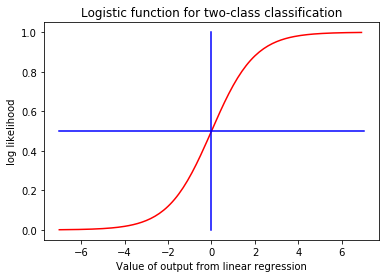

In [2]:
xseq = np.arange(-7, 7, 0.1)

logistic = [math.exp(v)/(1 + math.exp(v)) for v in xseq]

plt.plot(xseq, logistic, color = 'red')
plt.plot([-7,7], [0.5,0.5], color = 'blue')
plt.plot([0,0], [0,1], color = 'blue')
plt.title('Logistic function for two-class classification')
plt.ylabel('log likelihood')
plt.xlabel('Value of output from linear regression')

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. Substituting the linear model into the logistic function creates the following expression:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continuous output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$.

## Load and prepare the data set

As a first step, load the dataset. The code in the cell below loads the dataset and assigns human-readable names to the columns. Execute this code and examine the result. 

You should by now be very familiar with the next few sections as we have covered them in detail in previous labs.

In [21]:
credit['checking_account_status'].unique()

array(['< 0 DM', '0 - 200 DM', 'none', '> 200 DM or salary assignment'],
      dtype=object)

In [3]:
credit = pd.read_csv('German_Credit_Preped.csv')
print(credit.shape)
credit.head()

(1000, 22)


,customer_id,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,0
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,1


There are 22 columns, 1 customer identifier column, 20 features, plus a label column. These features represent information a bank might have on its customers. 

There is one other aspect of this data set which you should be aware of. The label has significant **class imbalance**. Class imbalance means that there are  unequal numbers of cases for the categories of the label. 

To examine the class imbalance in these data, execute the code in the cell below. 

In [4]:
credit_counts = credit[['credit_history', 'bad_credit']].groupby('bad_credit').count()
print(credit_counts)

            credit_history
bad_credit                
0                      700
1                      300


Notice that only 30% of the cases have bad credit. This is not surprising, since a bank would typically retain customers with good credit. However, this imbalance will bias the training of any model. 

Before proceeding, answer **Question 1** on the course page.

## Prepare data for scikit-learn model

With the data prepared, it is time to create the numpy arrays required for the scikit-learn model. 

The code in the cell below creates a numpy array of the label values. Execute this code. 

In [5]:
labels = np.array(credit['bad_credit'])

Now, you need to create the numpy feature array or **model matrix**. As first step, the categorical variables need to be recoded as binary dummy variables. As discussed in another lesson this is a three step process:

1. Encode the categorical string variables as integers.
2. Transform the integer coded variables to dummy variables. 
3. Append each dummy coded categorical variable to the model matrix. 

Execute the code in the cell below to perform this processing and examine the results. 

In [6]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['credit_history', 'purpose', 'gender_status', 
                       'time_in_residence', 'property']

Features = encode_string(credit['checking_account_status'])
for col in categorical_columns:
    temp = encode_string(credit[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(1000, 31)
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0.]]


/home/rockefeller/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/rockefeller/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='au

Next the numeric features must be concatenated to the numpy array by executing the code in the cell below. 

In [7]:
Features = np.concatenate([Features, np.array(credit[['loan_duration_mo', 'loan_amount', 
                            'payment_pcnt_income', 'age_yrs']])], axis = 1)
print(Features.shape)
print(Features[:2, :])   

(1000, 35)
[[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 6.000e+00 1.169e+03 4.000e+00 6.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 4.800e+01 5.951e+03 2.000e+00 2.200e+01]]


With the dummy variables the original 6 categorical features are now 31 dummy variables. With the 4 numeric features there are a total of 35. 

Now, answer **Question 2** on the course page.

You must split the cases into training and test data sets. This step is critical. If machine learning models are tested on the training data, the results will be both biased and overly optimistic.

The code in the cell below performs the following processing:
1. An index vector is Bernoulli sampled using the `train_test_split` function from the `model_selection` package of scikit-learn. 
2. The first column of the resulting index array contains the indices of the samples for the training cases. 
3. The second column of the resulting index array contains the indices of the samples for the test cases. 

Execute the code. 

In [8]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

There is just one more step in preparing this data. Numeric features must be rescaled so they have a similar range of values. Rescaling prevents features from having an undue influence on model training simply because then have a larger range of numeric variables.

The code in the cell below uses the StanardScaler function from the Scikit Learn preprocessing package to Zscore scale the numeric features. Notice that the scaler is fit only on the training data. The trained scaler is these applied to the test data. Test data should always be scaled using the parameters from the training data.

Execute this code.

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train[:,34:])
X_train[:,34:] = scaler.transform(X_train[:,34:])
X_test[:,34:] = scaler.transform(X_test[:,34:])
X_train[:2,]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  3.90000000e+01,  4.93300000e+03,
         2.00000000e+00, -9.33823618e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00

The four numeric features are now scaled. 

## Construct the logistic regression model

Now, it is time to compute the logistic regression model. The code in the cell below does the following:
1. Define a logistic regression model object using the `LogisticRegression` method from the scikit-learn `linear_model` package.
2. Fit the linear model using the numpy arrays of the features and the labels for the training data set.

Execute this code. 

In [10]:
logistic_mod = linear_model.LogisticRegression() 
logistic_mod.fit(X_train, y_train)

/home/rockefeller/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

The model has been computed. Notice that the configuration of the model object has been printed. In this case, only default settings are shown, since no arguments were given to create the model object. 

Now, print and examine the model coefficients by executing the code in the cell below. 

In [11]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-0.76726255]
[[-1.59657103e-02  7.39174970e-01 -2.94096299e-01 -1.19637551e+00
   3.97874665e-01 -1.12452732e+00 -4.21865254e-01  7.52535502e-01
  -3.71280141e-01 -6.79210161e-02  4.94529273e-01 -6.47572388e-01
   1.06890390e-01  1.34905351e-01  1.96724468e-02 -2.45605977e-01
  -4.09764729e-01  6.00288185e-02 -2.12424720e-01 -1.09391358e-01
   5.01018369e-02 -8.89492662e-02 -6.19023763e-01 -5.57311328e-01
   2.16341814e-01 -3.80659900e-01 -4.56331364e-02 -2.70121984e-01
  -1.02929314e-01 -5.25299151e-01  1.31087899e-01  2.29032336e-02
   5.97063112e-05  2.04544582e-01 -1.83369465e-01]]


First of all, notice that model coefficients look just as they would for an regression model. This is expected as previously explained. Additionally, nearly all the coefficients have the same magnitude indicating this model is likely to be overfit, given the number of features. 

Recall that the logistic regression model outputs probabilities for each class. The class with the highest probability is taken as the score (prediction). Execute the code and the cell below to compute and display a sample of these class probabilities for the test feature set. 

In [12]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.84581429 0.15418571]
 [0.40084163 0.59915837]
 [0.94197442 0.05802558]
 [0.31667386 0.68332614]
 [0.54804901 0.45195099]
 [0.97411768 0.02588232]
 [0.94822229 0.05177771]
 [0.62809343 0.37190657]
 [0.87424984 0.12575016]
 [0.92513055 0.07486945]
 [0.55946337 0.44053663]
 [0.40218548 0.59781452]
 [0.50481467 0.49518533]
 [0.67347627 0.32652373]
 [0.34061712 0.65938288]]


The first column is the probability of a score of $0$ and the second column is the probability of a score of $1$. Notice that for most, but not all cases, the probability of a score of $0$ is higher than $1$. 

## Score and evaluate the classification model

Now that the class probabilities have been computed these values must be transformed into actual class scores. Recall that the log likelihoods for two-class logistic regression are computed by applying the sigmoid or logistic transformation to the output of the linear model. The simple choice is to set the threshold between the two likelihoods at $0.5$. The code in the cell below applies this initial threshold to the probability of a score of $0$ for the test data. A few examples along with the known labels are then displayed. Execute this code and examine the result.

In [13]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 1 0 0 0 0 0 0 0 1 0 0 1]
[0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]


Some of the positive ($1$) predictions agree with the test labels in the second row, but several do not.

Given the results of the test data, how can you quantify the performance of the model? In general, you must **always use multiple metrics to evaluate the performance of any machine leaning model**, including classifiers. 

For classifiers there are a number of metrics commonly used. The **confusion matrix** lays out the correctly and incorrectly classified cases in a tabular format. There are various metrics derived from the values in the confusion matrix. Some of the common cases are briefly reviewed below. 

**Confusion matrix**

As already stated, the confusion matrix lays out correctly and incorrectly classified cases. For the binary (two-class) case the confusion matrix is organized as follows:

| | Scored Positive | Scored Negative|  
|------|:------:|:------:| 
|**Actual Positive** | True Positive | False Negative |
|**Actual Negative**| False Positive | True Negative |   

Here the four elements in the matrix are defined as:    
**True Positive** or **TP** are cases with positive labels which have been correctly classified as positive.     
**True Negative** or **TN** are cases with negative labels which have been correctly classified as negative.  
**False Positive** or **FP** are cases with negative labels which have been incorrectly classified as positive.   
**False Negative** or **FN** are cases with positive labels which have been incorrectly classified as negative.

When creating a confusion matrix it is important to understand and maintain a convention for which differentiating positive and negative label values. The usual convention is to call the $1$ case positive and the $0$ case negative. 

Notice that there is an ambiguity in which case is considered positive and which is considered negative when the confusion matrix is computed. Whenever you examine a confusion matrix it is a good idea to spend a moment and decide which case is which. This step will help you relate the results to the problem at hand. 

**Accuracy**

Accuracy is a simple and often misused metric. In simple terms, accuracy is the fraction of cases correctly classified. For a two-class classifier accuracy is written as:

$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$

Accuracy can be quite misleading. For example, say a classifier is used to detect fraudulent accounts and the rate of fraud is less than 1%. A naive model would be to say all accounts are not fraudulent. This model has accuracy exceeding  0.99. This sounds impressive, but is clearly useless. 

**Precision**

Precision is the fraction of correctly classified label cases out of all cases classified with that label value. We can express precision by the following relationship:

$$Precision = \frac{M_{i,i}}{\sum_j M_{i,j}}$$

In other words, the precision statistic is the number of correctly classified cases for the label value divided by all the cases in the column. Thus, precision is sensitive to the number of cases correctly classified for a given score value. 

**Recall**  

Recall is the fraction of cases of a label value correctly classified out of all cases that actually have that label value. We can express recall by the following relationship:

$$Recall = \frac{M_{i,i}}{\sum_i M_{i,j}}$$

In other words, the recall statistic is the number of correctly classified cases for the label value divided by all the cases in the row. Thus, precision is sensitive to the number of cases correctly classified for a given true label value. 

**F1**

The F1 statistic is weighted average of precision and recall. We can express F1 by the following relationship:

$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

In other words, F1 is a weighted metric for overall model performance. 

**ROC** and **AUC**

The receiver operating characteristic or ROC is a curve that displays the relationship between the true positive rate on the vertical axis and false positive rate on the horizontal axis. The ROC curve shows the tradeoff between true positive rate and false positive rate. An example is illustrated below.   

In principle, you can pick the desired operating point for a classifier on this curve. Towards the left favors low false positive rate at the expense of true positive rate. Towards the right favors high true positive rate at the expense of higher false positive rate.  



<img src="img/ROC_AUC.JPG" alt="drawing" width="480px"/>

<center>**ROC curve with values of AUC for balanced two-class problem**</center>

The AUC is the area or integral under the ROC curve. The overall performance of the classifier is measured by the area under the curve or AUC. But, how can you interpret a specific AUC value? The higher the AUC the lower the increase in false positive rate required to achieve a required true positive rate.  For an ideal classifier the AUC is 1.0. A true positive rate is achieved with a 0 false positive rate. This behavior means that AUC is useful for comparing classifiers. The classifier with higher AUC is generally the better one. 

For balanced cases, random guessing gives an AUC or 0.5. A balanced case has equal numbers of positive and negative cases. So Bernoulli sampling (random guessing) with a probability $p$ for the positive case, will produce a ROC curve that runs diagonally from $0.0,0.0$ to $1.0,1.0$. The area under this triangular region is 0.5. It is often said that a classifier with an AUC of greater than 0.5 is better than random guessing. But, **for unbalanced cases this statement is not in true in general**. 

****
**Note:** The term receive operating characteristic may seem a bit odd in the machine learning context. This term arose in the early days of radar engineering as a metric to measure the tradeoff between radar signal receiver correctly detecting a target, say an aircraft, and producing a positive response from noise, such as flying birds or clouds. A radar receiver would be adjusted to the desired operating point along its ROC curve. 
****

The code in the cell below implements a function that computes and displays the forementioned classifier performance metrics. The code metrics are computed using the `precision_recall_fscore_support` and `accuracy_score` functions from the `metrics` package of scikit-learn. The confusion matrix is computed using the `confusion_matrix` function from this same package. Execute this code and examine the results for the logistic regression model. 

In [14]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive       182                30
Actual negative        39                49

Accuracy  0.77
 
           Positive      Negative
Num case      212            88
Precision    0.82          0.62
Recall       0.86          0.56
F1           0.84          0.59


Examine these results:
1. The confusion matrix shows the following characteristics; a) most of the positive cases are correctly classified, 182 vs. 30, however, b) may negative cases are are scored incorrectly, with only 49 correct, vs. 39 incorrect.   
2. The overall accuracy is 0.77. However as just observed this is **extremely misleading!**. In fact the negative cases are poorly classified, and it is these bad credit customers the bank cares most about. This is not an unusual case. Accuracy figures should always be regarded with healthy skepticism.
3. The class imbalance is confirmed. Of the 300 test cases 212 are positive and 88 are negative. 
4. The precision, recall and F1 all show that positive cases are classified reasonably well, but the negative cases are not. As already mentioned, it is these negative cases that are of greatest importance to the bank. 

Finally, the code in the cell below computes and displays the ROC curve and AUC. The `roc_curve` and `auc` functions from the scikit-learn `metrics` package are used to compute these values. 

Execute this code, examine the result, and answer **Question 3** on the course page.

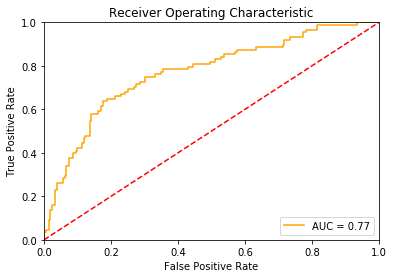

In [15]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)    

The ROC curve is above the diagonal red-dotted line and the AUC is 0.77. But, given the class imbalance of two positive cases for each negative case how good is this? 

One point of comparison is a naive 'classifier' that sets all cases to positive. The code in the cell below contains such a classifier. This algorithm is not really a classifier at all. This 'classifier' is hard coded. The ROC curve and AUC are then computed and displayed. Run this code, and examine the result. 

/home/rockefeller/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 Confusion matrix
                 Score positive    Score negative
Actual positive       212                 0
Actual negative        88                 0

Accuracy  0.71
 
           Positive      Negative
Num case      212            88
Precision    0.71          0.00
Recall       1.00          0.00
F1           0.83          0.00


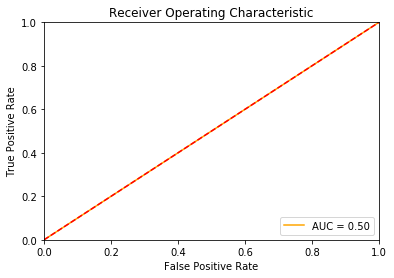

In [16]:
probs_positive = np.concatenate((np.ones((probabilities.shape[0], 1)), 
                                 np.zeros((probabilities.shape[0], 1))),
                                 axis = 1)
scores_positive = score_model(probs_positive, 0.5)
print_metrics(y_test, scores_positive)  
plot_auc(y_test, probs_positive) 

Notice, the accuracy from this 'classifier' is 0.71. This reflects the class imbalance. The ROC curve is directly along the diagonal which gives an AUC of 0.5. The logistic regression classifier is definitely better than this!

## Compute a weighted model

Recall that a falsely classifying a bad credit risk customer as good costs the bank five times more than classifying a good credit risk customer as bad. Given this situation, the results of the first model are not that good. There are two reasons for this:

1. The class imbalance in the label has biased the training of the model. As you observed from the accuracy of the naive 'classifier' is not that different from the logistic regression model. 
2. Nothing has been done to weight the results toward correctly classifying the bad credit risk customers at the expense of the good credit risk customers.

One approach to these problems is to weight the classes when computing the logistic regression model. The code in the cell below adds a `class_weight` argument to the call to the `LogisticRegression` function. In this case weights are chosen as $0.45, 0.55$  but you can also give another combination. Execute this code

In [17]:
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)

/home/rockefeller/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={0: 0.45, 1: 0.55}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Next, execute the code in the cell below to compute and display the class probabilities for each case. 

In [18]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.81671216 0.18328784]
 [0.35302546 0.64697454]
 [0.93010458 0.06989542]
 [0.28865367 0.71134633]
 [0.52038782 0.47961218]
 [0.96256847 0.03743153]
 [0.9303719  0.0696281 ]
 [0.57751695 0.42248305]
 [0.8500501  0.1499499 ]
 [0.89861855 0.10138145]
 [0.51975823 0.48024177]
 [0.37132182 0.62867818]
 [0.46768254 0.53231746]
 [0.6440636  0.3559364 ]
 [0.31003428 0.68996572]]


By eyeball, the above probabilities are not terribly different from the unweighted model. 

To find if there is any significant difference with the unweighted model, compute the scores and the metrics and display the metrics by executing the code in the cell below. 

Then, answer **Question 4** on the course page.

                 Confusion matrix
                 Score positive    Score negative
Actual positive       176                36
Actual negative        33                55

Accuracy  0.77
 
           Positive      Negative
Num case      212            88
Precision    0.84          0.60
Recall       0.83          0.62
F1           0.84          0.61


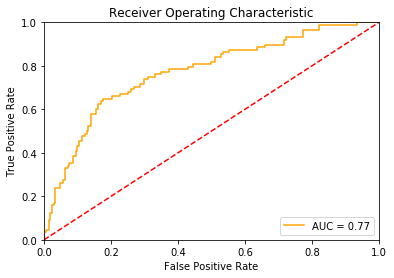

In [19]:
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  
plot_auc(y_test, probabilities)  

The accuracy is slightly changed with respect to the unweighted model. The change could be more had we give more weights to one of the class than what we did here. The precision, recall and F1 are slightly better for the negative cases. Reweighting the labels has moved the results in the desired direction, at least a bit.

Notice also, the ROC curve and AUC are essentially unchanged. The trade-off between true positive and false positive is similar to the unweighted model. 

## Find a better threshold

There is another way to tip the model scoring toward correctly identifying the bad credit cases. The scoring threshold can be adjusted. Until now, the scores have been computed from the probabilities using a threshold of 0.5. However, there is no reason to think this is the correct choice. Recall that the score is  determined by setting the threshold along the sigmoidal or logistic function. It is possible to favor either positive or negative cases by changing the threshold along this curve. 

The code in the cell below contains a function for scoring and evaluating the model for a given threshold value. The `for` loop iterates over the list of five candidate threshold values. Execute this code and examine how changing the threshold value changes the scoring for the model. 

In [20]:
def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

thresholds = [0.45, 0.40, 0.35, 0.3, 0.25]
for t in thresholds:
    test_threshold(probabilities, y_test, t)


For threshold = 0.45
                 Confusion matrix
                 Score positive    Score negative
Actual positive       164                48
Actual negative        30                58

Accuracy  0.74
 
           Positive      Negative
Num case      212            88
Precision    0.85          0.55
Recall       0.77          0.66
F1           0.81          0.60

For threshold = 0.4
                 Confusion matrix
                 Score positive    Score negative
Actual positive       151                61
Actual negative        26                62

Accuracy  0.71
 
           Positive      Negative
Num case      212            88
Precision    0.85          0.50
Recall       0.71          0.70
F1           0.78          0.59

For threshold = 0.35
                 Confusion matrix
                 Score positive    Score negative
Actual positive       142                70
Actual negative        22                66

Accuracy  0.69
 
           Positive      Negative
Num cas

As the threshold is decreased the number of correctly classified negative cases (bad credit customers) increases at the expense of correctly classifying positive cases (good credit customers). At the same time, accuracy decreases. However, as you have observed, accuracy is not a particularly useful metric here. 

Exactly which threshold to pick is a business decision. Notice that with a threshold value of 0.25 the number of false negatives (misclassified good credit customers) is about four times that of false positives (misclassified bad credit customers). 

## Summary

In this lesson you have done the following:
1. Prepared the credit risk data set for modeling with scikit-learn. The steps included scaling the numeric features, and dummy variable coding the categorical features. The result is a numpy array of features and a numpy array of the label values. 
2. Computed a logistic regression model. 
3. Evaluated the performance of the module using multiple metrics. It is clear that accuracy is not a particularly useful metric here. The naive 'classifier' produced accuracy that was only somewhat worse as a result of the class imbalance.  The confusion matrix and the precision, recall and F1 statistics gave meaningful measures of model performance, especially when considered together. 
4. Reweighted the labels and changed the decision threshold for the reweighted model. These steps helped overcome both the class imbalance problem and the asymmetric cost of misclassification to the bank. 